# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

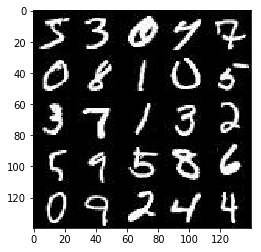

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

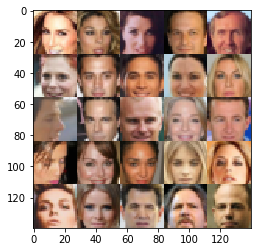

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="input_real")
    input_z = tf.placeholder(tf.float32, (None, z_dim), name="input_z")
    learning_rate = tf.placeholder(tf.float32)
    
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.1
    with tf.variable_scope("discriminator", reuse=reuse):
        # Input layer is 32x32x3
        x = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x = tf.maximum(alpha*x, x)
        
        x = tf.layers.conv2d(x, 128, 5, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(alpha*x, x)
        
        x = tf.layers.conv2d(x, 256, 5, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(alpha*x, x)
        
        flat = tf.reshape(x, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.1
    with tf.variable_scope('generator', reuse = (not is_train)):
        # First fully connected layer
        x = tf.reshape(tf.layers.dense(z, 7*7*448), (-1,7,7,448))
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha*x, x)
        
        # conv2
        x = tf.layers.conv2d_transpose(x, 224, 5, strides=1, padding='same')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha*x, x)
        
        # conv3
        x = tf.layers.conv2d_transpose(x, 112, 5, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha*x, x)
        
        
        # Output layer, 32x32x3
        logits = tf.layers.conv2d_transpose(x, out_channel_dim, 5, strides=2, padding='same')
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [13]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    d_train_opt = tf.train.AdamOptimizer(
        learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(
            learning_rate, beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [15]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, img_width, img_height, img_channels = data_shape
    
    real_input, z_input, lr = model_inputs(
        img_width, img_height, img_channels, z_dim)
    
    d_loss, g_loss = model_loss(real_input, z_input, img_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    print_every = 10
    show_every = 100
    losses = []
    n_images = 25

    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                    
                steps += 1
                batch_images *= 2.0
                z_sample = np.random.uniform(-1, 1, (batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={
                        real_input: batch_images, z_input: z_sample, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={
                        z_input: z_sample, lr: learning_rate})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({z_input: z_sample, real_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: z_sample})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % show_every == 0:
                    show_generator_output(sess, n_images, z_input, img_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0001... Generator Loss: 9.3529
Epoch 1/2... Discriminator Loss: 23.4206... Generator Loss: 0.0000
Epoch 1/2... Discriminator Loss: 4.7535... Generator Loss: 0.2089
Epoch 1/2... Discriminator Loss: 3.8878... Generator Loss: 9.2800
Epoch 1/2... Discriminator Loss: 0.5306... Generator Loss: 3.7288
Epoch 1/2... Discriminator Loss: 17.4694... Generator Loss: 17.9625
Epoch 1/2... Discriminator Loss: 0.3837... Generator Loss: 1.6114
Epoch 1/2... Discriminator Loss: 1.0419... Generator Loss: 2.0250
Epoch 1/2... Discriminator Loss: 0.5360... Generator Loss: 1.7133
Epoch 1/2... Discriminator Loss: 0.2014... Generator Loss: 3.6315


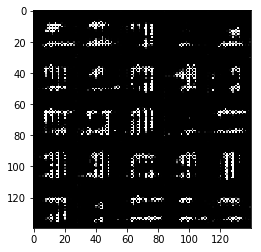

Epoch 1/2... Discriminator Loss: 0.2247... Generator Loss: 3.4436
Epoch 1/2... Discriminator Loss: 0.7301... Generator Loss: 1.4724
Epoch 1/2... Discriminator Loss: 0.3420... Generator Loss: 1.7988
Epoch 1/2... Discriminator Loss: 0.6358... Generator Loss: 1.2824
Epoch 1/2... Discriminator Loss: 0.5162... Generator Loss: 3.9128
Epoch 1/2... Discriminator Loss: 0.2628... Generator Loss: 2.2989
Epoch 1/2... Discriminator Loss: 1.1577... Generator Loss: 0.9095
Epoch 1/2... Discriminator Loss: 0.4999... Generator Loss: 2.5585
Epoch 1/2... Discriminator Loss: 0.9502... Generator Loss: 1.2937
Epoch 1/2... Discriminator Loss: 1.1801... Generator Loss: 0.5659


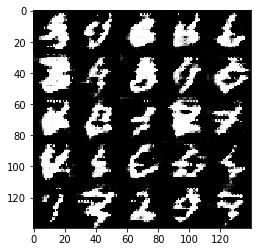

Epoch 1/2... Discriminator Loss: 0.2801... Generator Loss: 2.0184
Epoch 1/2... Discriminator Loss: 1.6470... Generator Loss: 0.8468
Epoch 1/2... Discriminator Loss: 0.7835... Generator Loss: 1.2623
Epoch 1/2... Discriminator Loss: 0.6439... Generator Loss: 1.2882
Epoch 1/2... Discriminator Loss: 1.0015... Generator Loss: 0.9612
Epoch 1/2... Discriminator Loss: 0.8288... Generator Loss: 1.3574
Epoch 1/2... Discriminator Loss: 1.5253... Generator Loss: 0.9452
Epoch 1/2... Discriminator Loss: 1.1599... Generator Loss: 0.8579
Epoch 1/2... Discriminator Loss: 1.1583... Generator Loss: 0.6407
Epoch 1/2... Discriminator Loss: 1.5198... Generator Loss: 0.5123


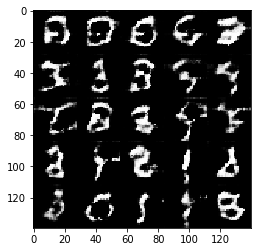

Epoch 1/2... Discriminator Loss: 1.3868... Generator Loss: 0.4251
Epoch 1/2... Discriminator Loss: 1.1722... Generator Loss: 1.0501
Epoch 1/2... Discriminator Loss: 1.7906... Generator Loss: 3.1948
Epoch 1/2... Discriminator Loss: 0.9878... Generator Loss: 0.8614
Epoch 1/2... Discriminator Loss: 0.9758... Generator Loss: 1.8163
Epoch 1/2... Discriminator Loss: 0.9679... Generator Loss: 0.8410
Epoch 1/2... Discriminator Loss: 2.9614... Generator Loss: 0.0880
Epoch 1/2... Discriminator Loss: 0.9467... Generator Loss: 0.9156
Epoch 1/2... Discriminator Loss: 1.0456... Generator Loss: 0.8748
Epoch 1/2... Discriminator Loss: 1.4169... Generator Loss: 0.6247


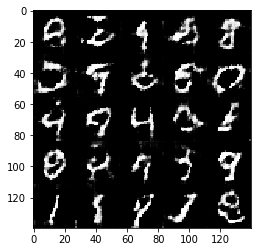

Epoch 1/2... Discriminator Loss: 2.0086... Generator Loss: 3.1037
Epoch 1/2... Discriminator Loss: 1.1652... Generator Loss: 0.8611
Epoch 1/2... Discriminator Loss: 1.0315... Generator Loss: 0.8368
Epoch 1/2... Discriminator Loss: 1.4634... Generator Loss: 0.6963
Epoch 1/2... Discriminator Loss: 1.1406... Generator Loss: 1.4522
Epoch 1/2... Discriminator Loss: 0.8755... Generator Loss: 0.8610
Epoch 1/2... Discriminator Loss: 1.2395... Generator Loss: 0.4930
Epoch 1/2... Discriminator Loss: 1.3962... Generator Loss: 2.3501
Epoch 1/2... Discriminator Loss: 0.9110... Generator Loss: 0.9265
Epoch 1/2... Discriminator Loss: 1.0731... Generator Loss: 0.7231


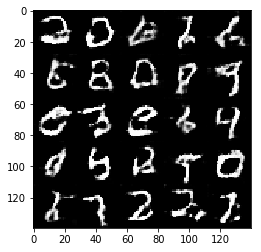

Epoch 1/2... Discriminator Loss: 1.0587... Generator Loss: 1.5662
Epoch 1/2... Discriminator Loss: 1.5683... Generator Loss: 0.5141
Epoch 1/2... Discriminator Loss: 0.9351... Generator Loss: 1.6284
Epoch 1/2... Discriminator Loss: 1.0504... Generator Loss: 1.2434
Epoch 1/2... Discriminator Loss: 0.8252... Generator Loss: 1.1068
Epoch 1/2... Discriminator Loss: 1.2068... Generator Loss: 1.2290
Epoch 1/2... Discriminator Loss: 1.1092... Generator Loss: 0.8065
Epoch 1/2... Discriminator Loss: 2.8958... Generator Loss: 0.1178
Epoch 1/2... Discriminator Loss: 0.8621... Generator Loss: 1.0973
Epoch 1/2... Discriminator Loss: 1.0020... Generator Loss: 0.8280


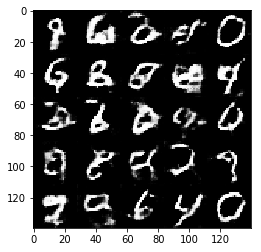

Epoch 1/2... Discriminator Loss: 0.8551... Generator Loss: 1.2089
Epoch 1/2... Discriminator Loss: 0.9941... Generator Loss: 0.8260
Epoch 1/2... Discriminator Loss: 0.4475... Generator Loss: 2.8194
Epoch 1/2... Discriminator Loss: 1.0305... Generator Loss: 0.8972
Epoch 1/2... Discriminator Loss: 0.7653... Generator Loss: 1.0462
Epoch 1/2... Discriminator Loss: 0.6493... Generator Loss: 1.5272
Epoch 1/2... Discriminator Loss: 1.1188... Generator Loss: 0.6889
Epoch 1/2... Discriminator Loss: 1.0220... Generator Loss: 0.7958
Epoch 1/2... Discriminator Loss: 0.9111... Generator Loss: 1.0298
Epoch 1/2... Discriminator Loss: 1.5759... Generator Loss: 0.4401


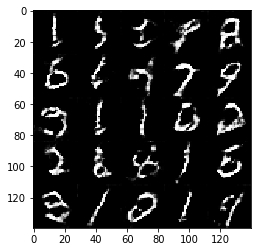

Epoch 1/2... Discriminator Loss: 0.7523... Generator Loss: 1.3715
Epoch 1/2... Discriminator Loss: 0.9651... Generator Loss: 1.0220
Epoch 1/2... Discriminator Loss: 1.0049... Generator Loss: 0.8181
Epoch 1/2... Discriminator Loss: 1.2764... Generator Loss: 0.5279
Epoch 1/2... Discriminator Loss: 0.9874... Generator Loss: 0.7604
Epoch 1/2... Discriminator Loss: 0.5707... Generator Loss: 1.6436
Epoch 1/2... Discriminator Loss: 0.4424... Generator Loss: 1.9990
Epoch 1/2... Discriminator Loss: 1.0587... Generator Loss: 0.9749
Epoch 1/2... Discriminator Loss: 0.6229... Generator Loss: 1.6151
Epoch 1/2... Discriminator Loss: 1.0411... Generator Loss: 1.0191


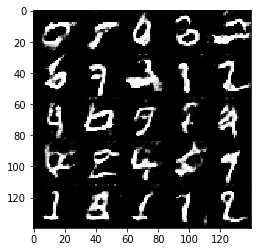

Epoch 1/2... Discriminator Loss: 1.2367... Generator Loss: 1.6228
Epoch 1/2... Discriminator Loss: 1.0173... Generator Loss: 0.7810
Epoch 1/2... Discriminator Loss: 0.7276... Generator Loss: 2.1754
Epoch 1/2... Discriminator Loss: 0.6753... Generator Loss: 1.3195
Epoch 1/2... Discriminator Loss: 0.7973... Generator Loss: 1.4772
Epoch 1/2... Discriminator Loss: 1.0876... Generator Loss: 1.1093
Epoch 1/2... Discriminator Loss: 1.1248... Generator Loss: 0.7542
Epoch 1/2... Discriminator Loss: 1.0759... Generator Loss: 0.7523
Epoch 1/2... Discriminator Loss: 1.0341... Generator Loss: 0.7681
Epoch 1/2... Discriminator Loss: 1.1947... Generator Loss: 0.6770


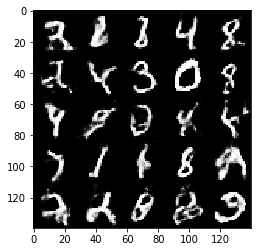

Epoch 1/2... Discriminator Loss: 1.0044... Generator Loss: 0.6438
Epoch 1/2... Discriminator Loss: 0.8737... Generator Loss: 1.1062
Epoch 1/2... Discriminator Loss: 2.0771... Generator Loss: 0.1981
Epoch 2/2... Discriminator Loss: 0.8368... Generator Loss: 1.1377
Epoch 2/2... Discriminator Loss: 1.0255... Generator Loss: 0.9600
Epoch 2/2... Discriminator Loss: 1.1017... Generator Loss: 0.7727
Epoch 2/2... Discriminator Loss: 1.9563... Generator Loss: 0.3300
Epoch 2/2... Discriminator Loss: 1.6771... Generator Loss: 4.0512
Epoch 2/2... Discriminator Loss: 0.8806... Generator Loss: 1.5788
Epoch 2/2... Discriminator Loss: 0.6974... Generator Loss: 1.9967


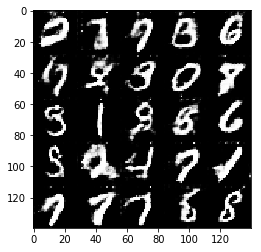

Epoch 2/2... Discriminator Loss: 0.8590... Generator Loss: 0.8861
Epoch 2/2... Discriminator Loss: 0.3250... Generator Loss: 2.1821
Epoch 2/2... Discriminator Loss: 0.1115... Generator Loss: 3.3845
Epoch 2/2... Discriminator Loss: 0.2929... Generator Loss: 6.1175
Epoch 2/2... Discriminator Loss: 0.7968... Generator Loss: 1.0828
Epoch 2/2... Discriminator Loss: 0.7759... Generator Loss: 1.2865
Epoch 2/2... Discriminator Loss: 0.4363... Generator Loss: 1.8289
Epoch 2/2... Discriminator Loss: 1.7223... Generator Loss: 0.4516
Epoch 2/2... Discriminator Loss: 0.7532... Generator Loss: 1.8027
Epoch 2/2... Discriminator Loss: 0.6990... Generator Loss: 1.3316


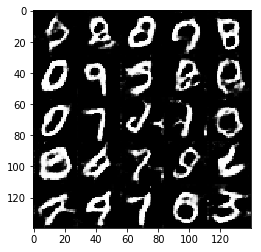

Epoch 2/2... Discriminator Loss: 0.6106... Generator Loss: 2.3502
Epoch 2/2... Discriminator Loss: 1.4216... Generator Loss: 0.5883
Epoch 2/2... Discriminator Loss: 0.5856... Generator Loss: 2.4747
Epoch 2/2... Discriminator Loss: 0.6902... Generator Loss: 1.4572
Epoch 2/2... Discriminator Loss: 0.7017... Generator Loss: 2.8113
Epoch 2/2... Discriminator Loss: 1.2294... Generator Loss: 0.6764
Epoch 2/2... Discriminator Loss: 0.9075... Generator Loss: 1.2039
Epoch 2/2... Discriminator Loss: 1.4704... Generator Loss: 0.4880
Epoch 2/2... Discriminator Loss: 0.7558... Generator Loss: 1.3889
Epoch 2/2... Discriminator Loss: 0.8208... Generator Loss: 1.9375


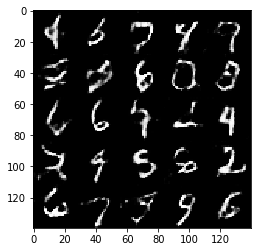

Epoch 2/2... Discriminator Loss: 0.5572... Generator Loss: 2.3546
Epoch 2/2... Discriminator Loss: 2.2138... Generator Loss: 4.3772
Epoch 2/2... Discriminator Loss: 0.7363... Generator Loss: 1.1499
Epoch 2/2... Discriminator Loss: 1.3359... Generator Loss: 0.6752
Epoch 2/2... Discriminator Loss: 1.3299... Generator Loss: 2.0886
Epoch 2/2... Discriminator Loss: 0.8333... Generator Loss: 1.1167
Epoch 2/2... Discriminator Loss: 2.2509... Generator Loss: 0.2473
Epoch 2/2... Discriminator Loss: 1.6021... Generator Loss: 0.4166
Epoch 2/2... Discriminator Loss: 0.8624... Generator Loss: 3.7437
Epoch 2/2... Discriminator Loss: 0.3772... Generator Loss: 2.2178


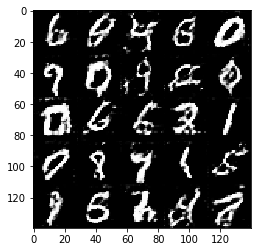

Epoch 2/2... Discriminator Loss: 0.1120... Generator Loss: 3.7622
Epoch 2/2... Discriminator Loss: 3.3250... Generator Loss: 0.2159
Epoch 2/2... Discriminator Loss: 0.8304... Generator Loss: 1.1587
Epoch 2/2... Discriminator Loss: 0.6442... Generator Loss: 1.6709
Epoch 2/2... Discriminator Loss: 1.8531... Generator Loss: 0.3378
Epoch 2/2... Discriminator Loss: 2.0706... Generator Loss: 0.3488
Epoch 2/2... Discriminator Loss: 1.7581... Generator Loss: 0.4391
Epoch 2/2... Discriminator Loss: 3.2599... Generator Loss: 6.7539
Epoch 2/2... Discriminator Loss: 0.8331... Generator Loss: 1.0300
Epoch 2/2... Discriminator Loss: 0.8103... Generator Loss: 1.3497


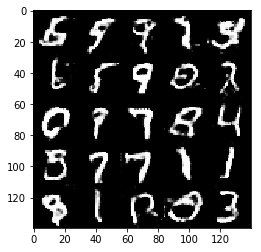

Epoch 2/2... Discriminator Loss: 2.7992... Generator Loss: 3.1516
Epoch 2/2... Discriminator Loss: 0.6891... Generator Loss: 1.4088
Epoch 2/2... Discriminator Loss: 1.6409... Generator Loss: 0.4565
Epoch 2/2... Discriminator Loss: 1.7037... Generator Loss: 0.4588
Epoch 2/2... Discriminator Loss: 1.2706... Generator Loss: 0.7244
Epoch 2/2... Discriminator Loss: 1.0459... Generator Loss: 1.1304
Epoch 2/2... Discriminator Loss: 0.8160... Generator Loss: 2.9471
Epoch 2/2... Discriminator Loss: 0.9637... Generator Loss: 1.9032
Epoch 2/2... Discriminator Loss: 1.4350... Generator Loss: 0.6403
Epoch 2/2... Discriminator Loss: 1.7903... Generator Loss: 0.6257


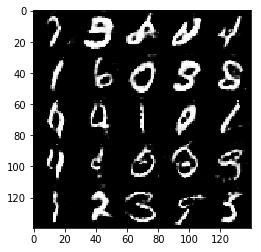

Epoch 2/2... Discriminator Loss: 0.8952... Generator Loss: 0.8770
Epoch 2/2... Discriminator Loss: 0.9272... Generator Loss: 0.9682
Epoch 2/2... Discriminator Loss: 0.8754... Generator Loss: 1.1973
Epoch 2/2... Discriminator Loss: 0.6316... Generator Loss: 2.9835
Epoch 2/2... Discriminator Loss: 0.6147... Generator Loss: 2.0092
Epoch 2/2... Discriminator Loss: 1.0444... Generator Loss: 0.6989
Epoch 2/2... Discriminator Loss: 1.3148... Generator Loss: 0.6656
Epoch 2/2... Discriminator Loss: 0.7140... Generator Loss: 1.2269
Epoch 2/2... Discriminator Loss: 1.3122... Generator Loss: 0.6419
Epoch 2/2... Discriminator Loss: 1.2873... Generator Loss: 0.8204


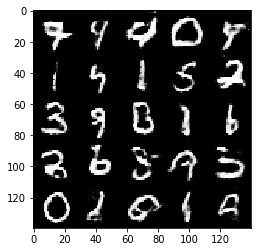

Epoch 2/2... Discriminator Loss: 1.2666... Generator Loss: 0.7244
Epoch 2/2... Discriminator Loss: 1.3007... Generator Loss: 4.0360
Epoch 2/2... Discriminator Loss: 1.4872... Generator Loss: 0.5195
Epoch 2/2... Discriminator Loss: 1.1202... Generator Loss: 4.8354
Epoch 2/2... Discriminator Loss: 3.2991... Generator Loss: 0.1607
Epoch 2/2... Discriminator Loss: 0.7912... Generator Loss: 1.2423
Epoch 2/2... Discriminator Loss: 1.0608... Generator Loss: 0.6694
Epoch 2/2... Discriminator Loss: 0.8296... Generator Loss: 1.0460
Epoch 2/2... Discriminator Loss: 1.2497... Generator Loss: 0.6012
Epoch 2/2... Discriminator Loss: 2.1548... Generator Loss: 0.2024


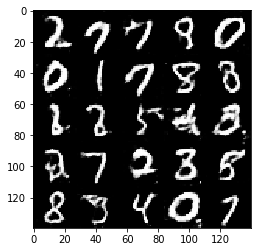

Epoch 2/2... Discriminator Loss: 0.8302... Generator Loss: 1.7040
Epoch 2/2... Discriminator Loss: 2.0507... Generator Loss: 0.2908
Epoch 2/2... Discriminator Loss: 1.5179... Generator Loss: 0.4894
Epoch 2/2... Discriminator Loss: 0.8935... Generator Loss: 1.0672
Epoch 2/2... Discriminator Loss: 1.7180... Generator Loss: 0.3541
Epoch 2/2... Discriminator Loss: 0.7806... Generator Loss: 1.2672
Epoch 2/2... Discriminator Loss: 0.3439... Generator Loss: 2.3702
Epoch 2/2... Discriminator Loss: 0.7701... Generator Loss: 1.2503
Epoch 2/2... Discriminator Loss: 0.4300... Generator Loss: 2.0668
Epoch 2/2... Discriminator Loss: 1.1074... Generator Loss: 0.6871


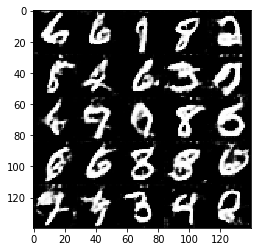

Epoch 2/2... Discriminator Loss: 1.5799... Generator Loss: 0.3910
Epoch 2/2... Discriminator Loss: 1.0417... Generator Loss: 1.0686
Epoch 2/2... Discriminator Loss: 1.2703... Generator Loss: 0.6686
Epoch 2/2... Discriminator Loss: 1.0589... Generator Loss: 1.0073
Epoch 2/2... Discriminator Loss: 2.2538... Generator Loss: 0.2081
Epoch 2/2... Discriminator Loss: 0.7541... Generator Loss: 1.1627
Epoch 2/2... Discriminator Loss: 1.2070... Generator Loss: 0.6778


In [16]:
batch_size = 64
z_dim = 100
learning_rate = 0.02
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.8452... Generator Loss: 0.8593
Epoch 1/1... Discriminator Loss: 0.6404... Generator Loss: 1.0937
Epoch 1/1... Discriminator Loss: 0.5882... Generator Loss: 1.2576
Epoch 1/1... Discriminator Loss: 0.3807... Generator Loss: 1.9519
Epoch 1/1... Discriminator Loss: 0.3453... Generator Loss: 2.0842
Epoch 1/1... Discriminator Loss: 0.4167... Generator Loss: 4.8471
Epoch 1/1... Discriminator Loss: 0.6363... Generator Loss: 2.0274
Epoch 1/1... Discriminator Loss: 0.4656... Generator Loss: 1.3628
Epoch 1/1... Discriminator Loss: 0.3483... Generator Loss: 2.8370
Epoch 1/1... Discriminator Loss: 0.4005... Generator Loss: 2.2636


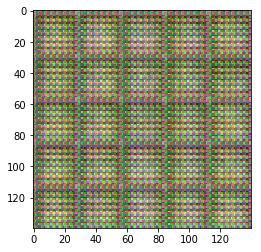

Epoch 1/1... Discriminator Loss: 0.5459... Generator Loss: 1.7071
Epoch 1/1... Discriminator Loss: 0.7470... Generator Loss: 1.9156
Epoch 1/1... Discriminator Loss: 0.6289... Generator Loss: 1.4912
Epoch 1/1... Discriminator Loss: 0.6164... Generator Loss: 1.5355
Epoch 1/1... Discriminator Loss: 0.4337... Generator Loss: 1.6732
Epoch 1/1... Discriminator Loss: 0.4377... Generator Loss: 1.8360
Epoch 1/1... Discriminator Loss: 0.3273... Generator Loss: 2.2398
Epoch 1/1... Discriminator Loss: 0.5642... Generator Loss: 1.8497
Epoch 1/1... Discriminator Loss: 0.4173... Generator Loss: 2.1021
Epoch 1/1... Discriminator Loss: 0.7833... Generator Loss: 1.1273


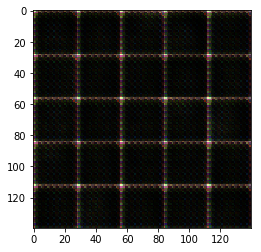

Epoch 1/1... Discriminator Loss: 0.8896... Generator Loss: 0.9899
Epoch 1/1... Discriminator Loss: 0.7104... Generator Loss: 1.1854
Epoch 1/1... Discriminator Loss: 1.1127... Generator Loss: 2.3373
Epoch 1/1... Discriminator Loss: 0.8356... Generator Loss: 1.6766
Epoch 1/1... Discriminator Loss: 0.9390... Generator Loss: 1.7593
Epoch 1/1... Discriminator Loss: 0.8179... Generator Loss: 1.3534
Epoch 1/1... Discriminator Loss: 0.7610... Generator Loss: 1.8396
Epoch 1/1... Discriminator Loss: 0.7946... Generator Loss: 1.3367
Epoch 1/1... Discriminator Loss: 0.8175... Generator Loss: 0.7993
Epoch 1/1... Discriminator Loss: 0.5790... Generator Loss: 1.4386


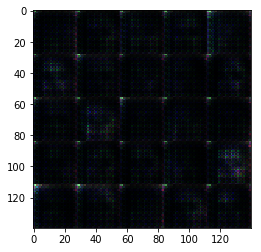

Epoch 1/1... Discriminator Loss: 1.0135... Generator Loss: 1.1605
Epoch 1/1... Discriminator Loss: 0.9479... Generator Loss: 2.2497
Epoch 1/1... Discriminator Loss: 0.8313... Generator Loss: 1.4809
Epoch 1/1... Discriminator Loss: 0.8341... Generator Loss: 1.2705
Epoch 1/1... Discriminator Loss: 0.5965... Generator Loss: 1.5735
Epoch 1/1... Discriminator Loss: 0.8546... Generator Loss: 2.5168
Epoch 1/1... Discriminator Loss: 0.6836... Generator Loss: 1.7719
Epoch 1/1... Discriminator Loss: 0.7842... Generator Loss: 1.0340
Epoch 1/1... Discriminator Loss: 0.7423... Generator Loss: 1.3699
Epoch 1/1... Discriminator Loss: 0.8383... Generator Loss: 0.9650


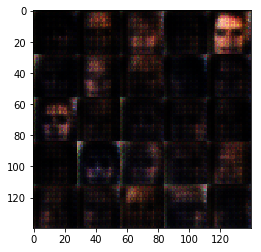

Epoch 1/1... Discriminator Loss: 0.5978... Generator Loss: 1.9642
Epoch 1/1... Discriminator Loss: 1.1390... Generator Loss: 0.7115
Epoch 1/1... Discriminator Loss: 0.9912... Generator Loss: 1.2689
Epoch 1/1... Discriminator Loss: 1.0424... Generator Loss: 1.7637
Epoch 1/1... Discriminator Loss: 1.1046... Generator Loss: 0.7501
Epoch 1/1... Discriminator Loss: 0.9477... Generator Loss: 0.9688
Epoch 1/1... Discriminator Loss: 1.0552... Generator Loss: 1.9384
Epoch 1/1... Discriminator Loss: 1.2839... Generator Loss: 0.5837
Epoch 1/1... Discriminator Loss: 1.0977... Generator Loss: 1.2919
Epoch 1/1... Discriminator Loss: 1.0250... Generator Loss: 0.7849


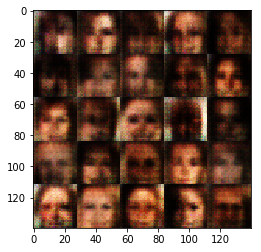

Epoch 1/1... Discriminator Loss: 0.9152... Generator Loss: 0.8607
Epoch 1/1... Discriminator Loss: 1.0384... Generator Loss: 1.4535
Epoch 1/1... Discriminator Loss: 1.0381... Generator Loss: 0.7395
Epoch 1/1... Discriminator Loss: 1.0692... Generator Loss: 1.6046
Epoch 1/1... Discriminator Loss: 1.0836... Generator Loss: 0.9148
Epoch 1/1... Discriminator Loss: 1.2821... Generator Loss: 0.7135
Epoch 1/1... Discriminator Loss: 1.1489... Generator Loss: 1.1164
Epoch 1/1... Discriminator Loss: 1.1345... Generator Loss: 0.9192
Epoch 1/1... Discriminator Loss: 1.0840... Generator Loss: 0.7505
Epoch 1/1... Discriminator Loss: 1.0537... Generator Loss: 0.8564


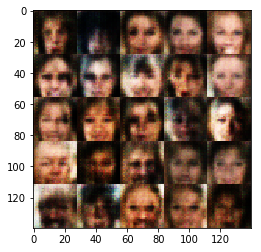

Epoch 1/1... Discriminator Loss: 1.2335... Generator Loss: 1.5921
Epoch 1/1... Discriminator Loss: 1.0173... Generator Loss: 1.1411
Epoch 1/1... Discriminator Loss: 0.9856... Generator Loss: 0.9166
Epoch 1/1... Discriminator Loss: 1.2832... Generator Loss: 1.8147
Epoch 1/1... Discriminator Loss: 1.0517... Generator Loss: 1.0560
Epoch 1/1... Discriminator Loss: 1.1085... Generator Loss: 1.0024
Epoch 1/1... Discriminator Loss: 1.0195... Generator Loss: 0.9391
Epoch 1/1... Discriminator Loss: 0.9167... Generator Loss: 1.1390
Epoch 1/1... Discriminator Loss: 1.1658... Generator Loss: 1.1513
Epoch 1/1... Discriminator Loss: 0.9871... Generator Loss: 1.3945


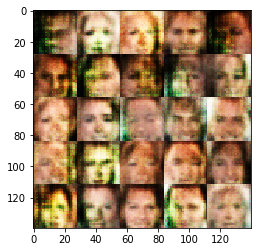

Epoch 1/1... Discriminator Loss: 1.0437... Generator Loss: 0.8236
Epoch 1/1... Discriminator Loss: 1.0896... Generator Loss: 0.6964
Epoch 1/1... Discriminator Loss: 1.2222... Generator Loss: 0.8777
Epoch 1/1... Discriminator Loss: 1.1662... Generator Loss: 0.9150
Epoch 1/1... Discriminator Loss: 1.1306... Generator Loss: 1.0537
Epoch 1/1... Discriminator Loss: 1.0377... Generator Loss: 1.2342
Epoch 1/1... Discriminator Loss: 1.0805... Generator Loss: 1.1246
Epoch 1/1... Discriminator Loss: 0.9930... Generator Loss: 1.0093
Epoch 1/1... Discriminator Loss: 1.1229... Generator Loss: 1.5101
Epoch 1/1... Discriminator Loss: 1.1144... Generator Loss: 1.0313


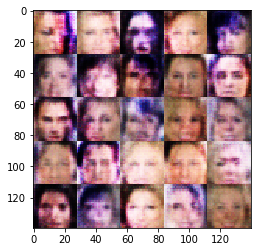

Epoch 1/1... Discriminator Loss: 1.0270... Generator Loss: 1.0890
Epoch 1/1... Discriminator Loss: 1.1176... Generator Loss: 1.5100
Epoch 1/1... Discriminator Loss: 1.1891... Generator Loss: 0.6868
Epoch 1/1... Discriminator Loss: 1.0505... Generator Loss: 1.0974
Epoch 1/1... Discriminator Loss: 1.2657... Generator Loss: 0.5282
Epoch 1/1... Discriminator Loss: 1.3695... Generator Loss: 0.5170
Epoch 1/1... Discriminator Loss: 1.1419... Generator Loss: 0.8493
Epoch 1/1... Discriminator Loss: 1.0996... Generator Loss: 0.8880
Epoch 1/1... Discriminator Loss: 0.9560... Generator Loss: 1.0305
Epoch 1/1... Discriminator Loss: 1.0742... Generator Loss: 0.9369


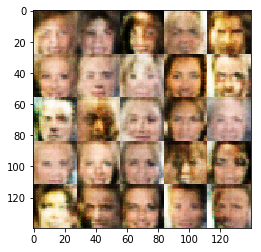

Epoch 1/1... Discriminator Loss: 1.0850... Generator Loss: 0.8328
Epoch 1/1... Discriminator Loss: 0.9596... Generator Loss: 1.0912
Epoch 1/1... Discriminator Loss: 1.1056... Generator Loss: 0.8249
Epoch 1/1... Discriminator Loss: 1.1504... Generator Loss: 0.8760
Epoch 1/1... Discriminator Loss: 1.1040... Generator Loss: 1.7371
Epoch 1/1... Discriminator Loss: 1.1038... Generator Loss: 0.9869
Epoch 1/1... Discriminator Loss: 1.1140... Generator Loss: 0.8450
Epoch 1/1... Discriminator Loss: 1.1491... Generator Loss: 0.8977
Epoch 1/1... Discriminator Loss: 1.2582... Generator Loss: 0.7291
Epoch 1/1... Discriminator Loss: 0.9390... Generator Loss: 1.2382


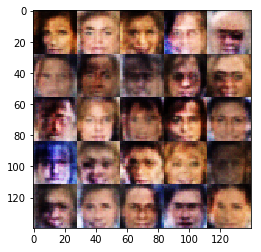

In [17]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.